In [79]:
import os
import sys

import math
import re
import datetime as dt
import copy 
from typing import Union, Iterable, Tuple

import pandas as pd
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt
plt.style.use('seaborn')

In [31]:
def get_neighbors(array:np.ndarray, left:bool) -> np.ndarray:
    if left:
        pad_width = (1, 0)
        delete = len(array)
    else:
        pad_width = (0, 1)
        delete = 0
    mode = 'constant'
    neighbors = np.delete(np.pad(array, pad_width=pad_width, mode='constant'), delete)
    return neighbors
    

In [34]:
def get_morph(array:np.ndarray) -> np.ndarray:
    right_neighbor = get_neighbors(array, left=False)
    left_neighbor = get_neighbors(array, left=True)
    avg_neighbor = (right_neighbor + left_neighbor) / 2
    morph_values = avg_neighbor - array
    return morph_values

In [64]:
def morph_as_heat(array:Union[np.ndarray, pd.Series], n_steps:int=1) -> np.ndarray:
    '''
    Morph the sorted array or series by using n_steps of evolution of a heat diffusion system.
    '''
    is_series = isinstance(array, pd.Series)
    if is_series:
        idx = array.index
        name = array.name
        dtype = array.dtype
        array = array.to_numpy()
    
    morphed_array = array.copy()
    for step in range(n_steps):
        if step == 0:
            morph_values = get_morph(array=morphed_array)
            morphed_array = morphed_array  + morph_values
        else:
            morphed_array = morph_as_heat(morphed_array)
    
    if is_series:
        morphed_array = pd.Series(morphed_array, index=idx, name=name, dtype=dtype)
    return morphed_array
    

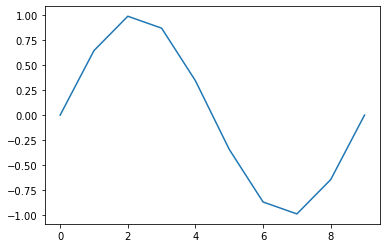

In [41]:
ary = np.sin(np.linspace(0, 2*math.pi, 10))
plt.plot(ary)

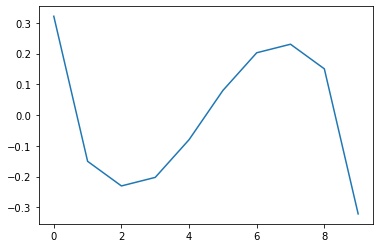

In [47]:
plt.plot(get_morph(ary))

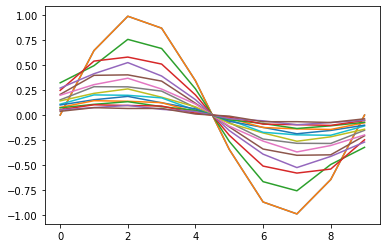

In [66]:
fig, ax = plt.subplots()
ax.plot(ary)
for s in range(15):
    ax.plot(morph_as_heat(ary, s))

In [71]:
data = pd.read_csv('data.csv')
data.loc[:, 'visit_dt'] = pd.to_datetime(data.loc[:, 'visit_dt'])
data = data.set_index('visit_dt')

In [74]:
to_morph = data.loc[:, 'rtl_tot_amt']

In [80]:
one_morph = morph_as_heat(to_morph)
two_morph = morph_as_heat(to_morph, 2)
three_morph = morph_as_heat(to_morph, 3)

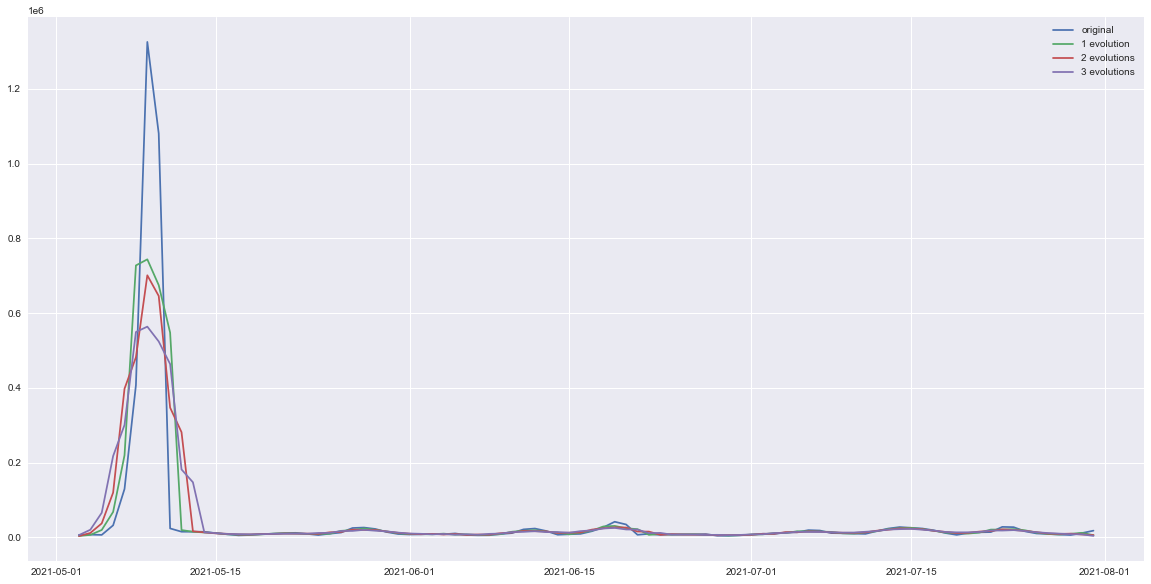

In [81]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(to_morph, label='original')
ax.plot(one_morph, label='1 evolution')
ax.plot(two_morph, label='2 evolutions')
ax.plot(three_morph, label='3 evolutions')
ax.legend()

In [82]:
morphed_df = data.copy()

In [85]:
morphed_df.loc[:, ['1_evo', '2_evo', '3_evo']] = np.vstack([one_morph, two_morph, three_morph]).T

In [87]:
morphed_df.to_csv('morph_attempt.csv')

In [92]:
stack_list = list()
for col in morphed_df.columns:
    stack_df = morphed_df.loc[:, [col]].rename(columns={col:'value'})
    stack_df.loc[:, 'evo'] = col
    stack_list.append(stack_df)

In [93]:
vertical_df = pd.concat(stack_list)

In [95]:
vertical_df.to_csv('morph_attempt_v.csv')